# 使用TensorFlow处理GMM模型
参考[为什么统计学家也应该学学 TensorFlow](https://cosx.org/2017/08/tensorflow-for-statisticians/)

### 生成模拟数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
np.random.seed(123)

In [4]:
# parameters
p1 = 0.3
p2 = 0.7
mu1 = 0.0
mu2 = 5.0
sigma1 = 1.0
sigma2 = 1.5

In [5]:
# simulate data
N = 1000
x = np.zeros(N)
ind = np.random.binomial(1, p1, N).astype('bool_')
n1 = ind.sum()
x[ind] = np.random.normal(mu1, sigma1, n1)
x[np.logical_not(ind)] = np.random.normal(mu2, sigma2, N-n1)
## 注意这种混合分布模拟数据的生成方式
## 0.3N(0, 1) + 0.7N(5, 1.5^2)

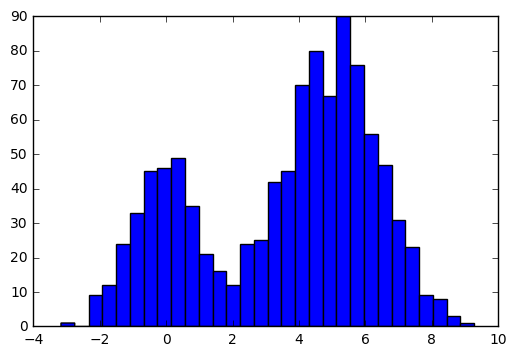

In [6]:
# Histogram
plt.hist(x, bins=30)
plt.show()

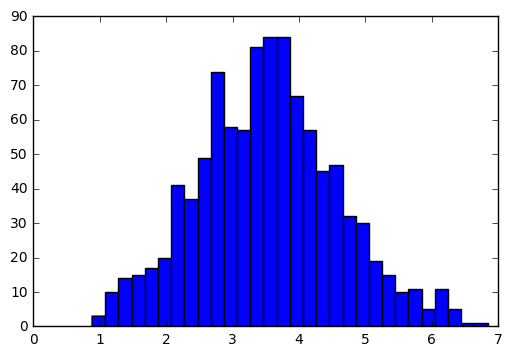

In [7]:
# 直接相加减
y = np.zeros(N)
y = np.random.normal(mu1, sigma1, N)*0.3 + np.random.normal(mu2, sigma2, N)*0.7
plt.hist(y, bins=30)
plt.show()

###  GMM模型估计

In [9]:
import tensorflow as tf
import tensorflow.contrib.distributions as ds

In [10]:
# define data
t_x = tf.placeholder(tf.float32)

# define parameters
t_p1_ = tf.Variable(0.0, dtype = tf.float32)
t_p1 = tf.nn.softplus(t_p1_)
t_mu1 = tf.Variable(0.0, dtype = tf.float32)
t_mu2 = tf.Variable(1.0, dtype = tf.float32)
t_sigma1_ = tf.Variable(1.0, dtype = tf.float32)
t_sigma1 = tf.nn.softplus(t_sigma1_)
t_sigma2_ = tf.Variable(1.0, dtype = tf.float32)
t_sigma2 = tf.nn.softplus(t_sigma2_)

# define model and objective function
t_gm = ds.Mixture(
    cat = ds.Categorical(probs=[t_p1, 1.0-t_p1]),
    components=[
        ds.Normal(t_mu1, t_sigma1),
        ds.Normal(t_mu2, t_sigma2)
    ]
)
t_ll = tf.reduce_mean(t_gm.log_prob(t_x))

# optimization
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(-t_ll)

# run
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for _ in range(500):
    sess.run(train, {t_x: x})
    
print('Estimated values:', sess.run([t_p1, t_mu1, t_mu2, t_sigma1, t_sigma2]))
print('True values:', [p1, mu1, mu2, sigma1, sigma2])

('Estimated values:', [0.29020733, -0.078560397, 5.0137568, 0.9575491, 1.4157517])
('True values:', [0.3, 0.0, 5.0, 1.0, 1.5])


In [11]:
# for data y
for _ in range(500):
    sess.run(train, {t_x: y})
    
print('Estimated values:', sess.run([t_p1, t_mu1, t_mu2, t_sigma1, t_sigma2]))
print('True values:', [p1, mu1, mu2, sigma1, sigma2])

('Estimated values:', [0.015389269, 2.1191218, 3.5452435, 0.87701946, 1.0529736])
('True values:', [0.3, 0.0, 5.0, 1.0, 1.5])
